# Setup

## Packages and Working Directory

In [1]:
%%bash
pip install kaggle -U scikit-learn category_encoders 
cp /content/drive/MyDrive/pyism/kaggle.json /content
cp /content/drive/MyDrive/pyism/{kaggle_data,utils}.py /content

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["image.cmap"] = "Set2"

BASE_DIR = os.getcwd()
PROJECT_DIR = os.path.join(BASE_DIR, 'drive', 'MyDrive', 'Colab Notebooks', 'projects', 'bulldozers')


## Download & Read In Data 

In [3]:
import kaggle_data
competition = "bluebook-for-bulldozers"
file_name = ['Data Dictionary.xlsx','Train.zip', 'Valid.zip','ValidSolution.csv']

kaggle_api, _ = kaggle_data.activate_kaggle(competition, kaggle_credential_path="/content/kaggle.json")
kaggle_data.download_file_kaggle(kaggle_api, competition, False, *file_name)

kaggle.json Copied!
---------------------------------------------
List of Data Files of bluebook-for-bulldozers: 
random_forest_benchmark_test.csv
Valid.csv
Train.zip
Machine_Appendix.csv
ValidSolution.csv
median_benchmark.csv
TrainAndValid.zip
Valid.zip
TrainAndValid.7z
Data Dictionary.xlsx
Valid.7z
Train.7z
Test.csv
TrainAndValid.csv


100%|██████████| 10.8k/10.8k [00:00<00:00, 11.6MB/s]

100%|██████████| 9.28M/9.28M [00:00<00:00, 67.8MB/s]

100%|██████████| 297k/297k [00:00<00:00, 69.5MB/s]

100%|██████████| 316k/316k [00:00<00:00, 91.5MB/s]

In [4]:
train = pd.read_csv("Train.zip", low_memory=False, parse_dates=['saledate'])
valid = pd.read_csv("Valid.zip", low_memory=False, parse_dates=['saledate'])
valid_sol = pd.read_csv("ValidSolution.csv").drop(columns='Usage')
valid = valid.merge(valid_sol, on='SalesID')


# read in the description
pd.options.display.max_colwidth = None
data_dict = pd.read_excel('Data%20Dictionary.xlsx').drop(columns=['Unnamed: 2'])


/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [5]:
before2011 = train.saledate < "2011-01-01"
trn = train.loc[before2011, :].copy()
val = train.loc[~before2011, :].copy()
trn.shape, val.shape

((365928, 53), (35197, 53))

# EDA

## Feature Definition

In [6]:
data_dict.set_index('Variable', inplace=True)

In [7]:
# SalesID is completely unique (having the same count as the sample counts), 
# so it wouldn't have any significant effect in training. 
print(data_dict.loc['SalesID'])
train.SalesID.nunique(), train.shape

Description      unique identifier of a particular sale of a machine at auction
Name: SalesID, dtype: object


(401125, (401125, 53))

In [8]:
# fiModelDesc is the combination of 4 other features.
# It means we can remove it and still can deduce it if we need to.
print(data_dict.loc['ModelID'])
print(data_dict.loc['fiModelDesc'])
train[['fiModelDesc','fiBaseModel','fiSecondaryDesc','fiModelSeries','fiModelDescriptor']]

Description      identifier for a unique machine model (i.e. fiModelDesc)
Name: ModelID, dtype: object
Description      Description of a unique machine model (see ModelID); concatenation of fiBaseModel & fiSecondaryDesc & fiModelSeries & fiModelDescriptor
Name: fiModelDesc, dtype: object


,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor
0,521D,521,D,NaN,NaN
1,950FII,950,F,II,NaN
2,226,226,NaN,NaN,NaN
3,PC120-6E,PC120,NaN,-6E,NaN
4,S175,S175,NaN,NaN,NaN
...,...,...,...,...,...
401120,35NX2,35,NX,2,NaN
401121,35NX2,35,NX,2,NaN
401122,35NX2,35,NX,2,NaN
401123,30NX,30,NX,NaN,NaN


In [9]:
# ProductGroup is just abbreviation for ProductGroupDesc
# It means we can remove either one 
print(data_dict.loc['ProductGroup'])
print(data_dict.loc['ProductGroupDesc'])

train[['ProductGroup', 'ProductGroupDesc']].value_counts()

Description      identifier for top-level hierarchical grouping of fiModelDesc
Name: ProductGroup, dtype: object
Description      description of top-level hierarchical grouping of fiModelDesc
Name: ProductGroupDesc, dtype: object


ProductGroup  ProductGroupDesc   
TEX           Track Excavators       101167
TTT           Track Type Tractors     80520
BL            Backhoe Loaders         79415
WL            Wheel Loader            71046
SSL           Skid Steer Loaders      43488
MG            Motor Graders           25489
dtype: int64

In [10]:
drop_cols = ['ProductGroup', 'fiModelDesc', 'SalesID']
for df in [train, valid, trn, val]:
    df.drop(columns=drop_cols, inplace=True)

## Summary

In [11]:
trn.describe(exclude=[np.number]).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,count,unique,top,freq,first,last
UsageBand,52527,3,Medium,25159,NaT,NaT
saledate,365928,3656,2009-02-16 00:00:00,1932,1989-01-17,2010-12-30
fiBaseModel,365928,1914,580,18539,NaT,NaT
fiSecondaryDesc,238877,167,C,39318,NaT,NaT
fiModelSeries,51392,115,II,11717,NaT,NaT
fiModelDescriptor,62609,136,L,14022,NaT,NaT
ProductSize,173202,6,Medium,56408,NaT,NaT
fiProductClassDesc,365928,74,Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth,51418,NaT,NaT
state,365928,53,Florida,58248,NaT,NaT
ProductGroupDesc,365928,6,Track Excavators,91745,NaT,NaT


In [12]:
trn.describe()

,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
count,365928.000000,3.659280e+05,365928.000000,365928.000000,345792.000000,365928.000000,1.202800e+05
mean,30830.913013,1.197766e+06,6722.048321,133.526385,6.567058,1896.774647,3.239153e+03
std,22835.041483,4.148507e+05,6036.391228,7.041611,16.718941,294.170934,2.995679e+04
min,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00
25%,14500.000000,1.092230e+06,3257.000000,132.000000,1.000000,1984.000000,0.000000e+00
50%,24000.000000,1.273301e+06,4604.000000,132.000000,2.000000,1994.000000,0.000000e+00
75%,39500.000000,1.451946e+06,8426.000000,136.000000,4.000000,2000.000000,2.258000e+03
max,142000.000000,2.386738e+06,37198.000000,172.000000,99.000000,2012.000000,2.483300e+06


In [13]:
trn.select_dtypes(include=['number']).nunique()

SalePrice                      865
MachineID                   313558
ModelID                       5040
datasource                       5
auctioneerID                    30
YearMade                        69
MachineHoursCurrentMeter     13042
dtype: int64

* The range of `SalePrice` seems to be wide. The *max* and *min* are far from the third and first quantiles, respectively. 
* For `YearMade`, there is a huge difference between *mean* and the *median*; indeed, the *mean* is closer to the *first quantile*. This signals the presence of *outlier*s from the left. Also, the minimum is `1000`, which is far from the *.25 quantile*. It's possible that missing value for `YearMade` is encoded as `1000`.
* `MachineHoursCurrentMeter` suffers the same issue. The *min* and the *first and second quantiles* are all zeros, signalling that the value 0 is indicate missing values.
* `datasource` and  `auctioneerID` have a relatively small cardinality, so we should consider them categorical features. 

In [14]:
to_replace = dict(
    YearMade={1000:np.nan}, 
    MachineHoursCurrentMeter={0:np.nan}
)

for df in [train, valid, trn, val]:
    df.replace(to_replace=to_replace, value=None, inplace=True)
    df[['datasource','auctioneerID']] = df[['datasource','auctioneerID']].astype('category')

In [15]:
trn.describe()

,SalePrice,MachineID,ModelID,YearMade,MachineHoursCurrentMeter
count,365928.000000,3.659280e+05,365928.000000,330409.000000,5.252700e+04
mean,30830.913013,1.197766e+06,6722.048321,1993.178010,7.417238e+03
std,22835.041483,4.148507e+05,6036.391228,9.657302,4.498869e+04
min,4750.000000,0.000000e+00,28.000000,1919.000000,2.000000e+00
25%,14500.000000,1.092230e+06,3257.000000,1987.000000,1.400000e+03
50%,24000.000000,1.273301e+06,4604.000000,1995.000000,2.725000e+03
75%,39500.000000,1.451946e+06,8426.000000,2000.000000,5.565000e+03
max,142000.000000,2.386738e+06,37198.000000,2012.000000,2.483300e+06


## Numerical Variables

### `YearMade`

In [16]:
x = trn.YearMade.copy()
x.nunique(), x.isna().sum()

(68, 35519)

If we group the data by `YearMade`, calculate each group mean, and plot them, we can see that, excep for the 1920-1960 timeframe, the more recent a machine is produced, the higher its expected `SalePrice`.  However, the average price and the number of machines made suddenly drop from 2008 moving forwards. It's probably due to the financial crisis in 2008. Also, the period between 1920 and 1960 saw multiple abnormal spikes. It's is the result of lacking data points, which is evident in the box plot. 

The scatter plot reflects the same pattern; that's, newer machines are more likely to be expensive. However, it's also apparent that these machines take on a wide range of prices regradless their manufactured year.

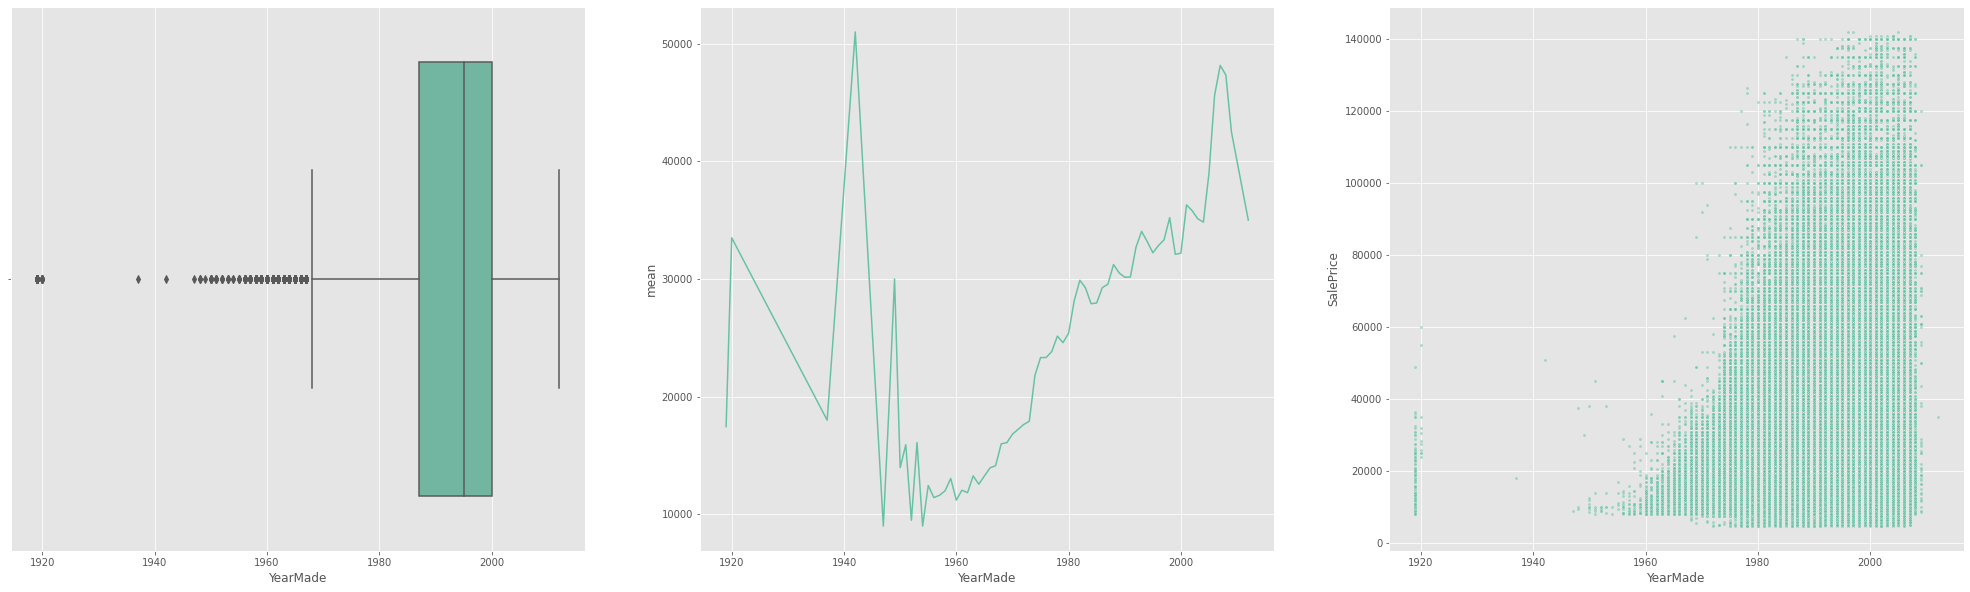

In [17]:
year_grps = trn.groupby('YearMade')['SalePrice'].agg(['mean', 'count'])
sns.set_palette('Set2') 

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(35, 10))
sns.boxplot(x=trn.YearMade, ax=ax0)
sns.lineplot(x=year_grps.index, y=year_grps['mean'], ax=ax1)
sns.scatterplot(x=trn.YearMade, y=trn.SalePrice, s=10, alpha=.5, ax=ax2)

The **auto-correlation** and partial **auto-correlation** show that the average product price made in a specific year is highly correlated with the previous year and the year before that. In simple words, knowing the average price of bulldozers maded in last 2 years is somewhat useful in explaining the price of products maded in the current year.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


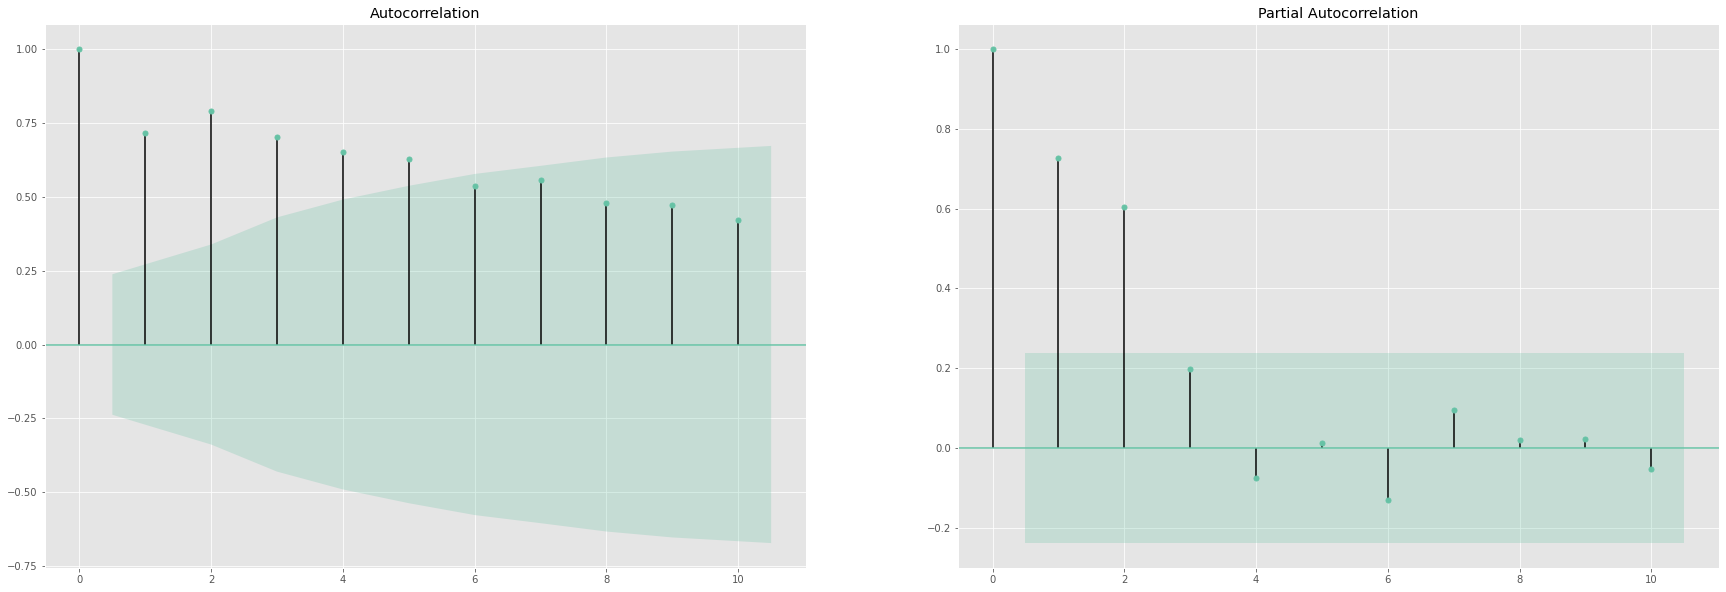

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
acf = plot_acf(x=year_grps['mean'], lags=10, ax=ax0)
pacf = plot_pacf(x=year_grps['mean'], lags=10, ax=ax1)


#### Fill NAs by Binning `SalePrice`

In [19]:
y = trn.SalePrice
def cutNfill(df, x, y, **kwargs):
    cuts = pd.cut(df[y], **kwargs)
    to_fill = pd.concat([df[x], cuts], axis=1).groupby(y)[x].mean().to_dict()
    t = cuts.map(to_fill).astype(df[x].dtype)
    return df[x].fillna(t).round()

x1t = cutNfill(trn, 'YearMade', 'SalePrice', bins=3)
x1v = cutNfill(val, 'YearMade', 'SalePrice', bins=3)

x0t = trn.YearMade.fillna(trn.YearMade.mean())
x0v = val.YearMade.fillna(trn.YearMade.mean())

yt = np.log1p(trn.SalePrice)
yv = np.log1p(val.SalePrice)

In [20]:
def compare_features(h0, h1, ys):
    scores = []
    yt, yv = ys
    for t, v in (h0, h1):
        print(t.shape, v.shape)
        tree = DecisionTreeRegressor().fit(t.values[:, None], yt)
        score = np.sqrt(mean_squared_error(yv, tree.predict(v.values[:,None])))
        scores.append(score)
    return scores

compare_features([x0t, x0v],[x1t, x1v], (yt, yv))

(365928,) (35197,)
(365928,) (35197,)


[0.6939253121308843, 0.6944864865883273]

#### Fill NAs by Grouping A Categorical Data

In [21]:
from category_encoders import JamesSteinEncoder
from utils import feature_importances

def find_feature(df, y, target='SalePrice', drop_cols=['saledate'], model=DecisionTreeRegressor(),**kwargs):
    X, Y = df.drop(columns=drop_cols + [target, y]), df[y]
    js = JamesSteinEncoder()
    X_transformed = js.fit_transform(X, df[target])
    X_transformed = X_transformed[Y.notna()].fillna(method='ffill')
    m = model.fit(X_transformed, Y[Y.notna()])
    imp = m.feature_importances_
    return feature_importances(m, X_transformed.columns, imp, **kwargs)

find_feature(trn, 'YearMade', threshold=.9)

,importance,rank,norm_cummulative
features,,,
ModelID,0.294929,1,0.294929
fiSecondaryDesc,0.146536,2,0.441465
ProductGroupDesc,0.132166,3,0.573630
Enclosure,0.090649,4,0.664279
fiBaseModel,0.065760,5,0.730039
MachineHoursCurrentMeter,0.064482,6,0.794521
datasource,0.051707,7,0.846228
fiProductClassDesc,0.045009,8,0.891236


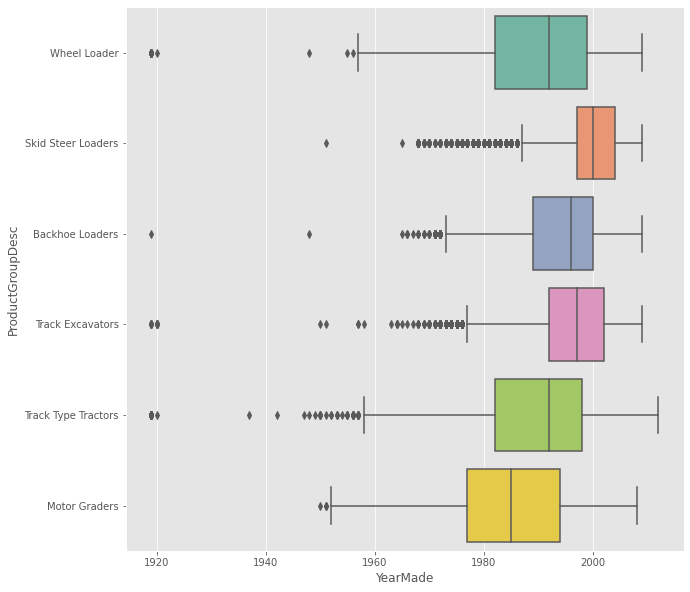

In [22]:
sns.boxplot(data=trn, x='YearMade', y='ProductGroupDesc', palette='Set2')

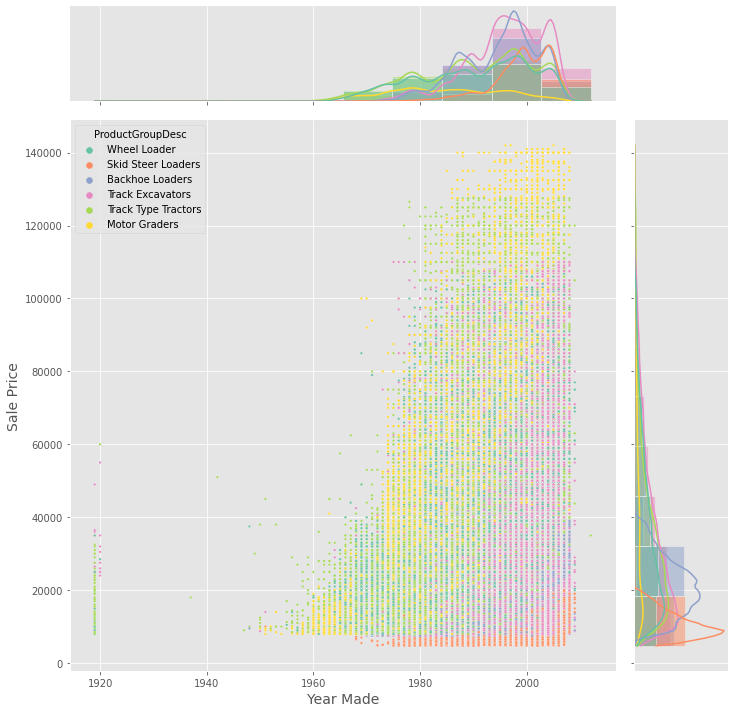

In [23]:
ym = sns.JointGrid(x=x, y=trn.SalePrice,
                   height=10, hue=trn.ProductGroupDesc, palette='Set2')
ym.plot_joint(sns.scatterplot, s=6)
ym.plot_marginals(sns.histplot, kde=True, bins=10)
ym.set_axis_labels(xlabel='Year Made', ylabel='Sale Price', fontsize=14)

In [24]:
trn.ProductGroupDesc.value_counts(dropna=False)

Track Excavators       91745
Track Type Tractors    73952
Backhoe Loaders        72993
Wheel Loader           65035
Skid Steer Loaders     38879
Motor Graders          23324
Name: ProductGroupDesc, dtype: int64

In [25]:
ym_groups = trn.groupby('ProductGroupDesc', dropna=False).YearMade
to_fill = ym_groups.mean().to_dict()
to_fill

{'Backhoe Loaders': 1994.8858464141915,
 'Motor Graders': 1984.7742758156096,
 'Skid Steer Loaders': 1999.0914762691584,
 'Track Excavators': 1996.1605463165024,
 'Track Type Tractors': 1990.0483378310253,
 'Wheel Loader': 1990.1723610142685}

In [26]:
x1t = trn.YearMade.fillna(trn.ProductGroupDesc.map(to_fill))
x1v = val.YearMade.fillna(val.ProductGroupDesc.map(to_fill))

x0t = trn.YearMade.fillna(trn.YearMade.mean())
x0v = val.YearMade.fillna(trn.YearMade.mean())

compare_features([x0t, x0v],[x1t, x1v], (yt, yv))

(365928,) (35197,)
(365928,) (35197,)


[0.6939253121308843, 0.6890101523045838]

In [27]:
ym_groups = train.groupby('ProductGroupDesc', dropna=False).YearMade
to_fill = ym_groups.mean().to_dict()
to_fill

{'Backhoe Loaders': 1995.364524559405,
 'Motor Graders': 1985.3004725939668,
 'Skid Steer Loaders': 1999.5315586849704,
 'Track Excavators': 1996.6905081950547,
 'Track Type Tractors': 1990.6853583826833,
 'Wheel Loader': 1990.7921143604597}

In [28]:
train.YearMade.describe()

count    362940.000000
mean       1993.757403
std           9.684227
min        1919.000000
25%        1988.000000
50%        1996.000000
75%        2001.000000
max        2013.000000
Name: YearMade, dtype: float64

In [29]:
train['YearMade_na'] = train.YearMade.isna()
valid['YearMade_na'] = valid.YearMade.isna()

train.YearMade = train.YearMade.fillna(train.ProductGroupDesc.map(to_fill))
valid.YearMade = valid.YearMade.fillna(valid.ProductGroupDesc.map(to_fill))

In [30]:
train.YearMade.describe()

count    401125.000000
mean       1993.762084
std           9.290590
min        1919.000000
25%        1989.000000
50%        1996.000000
75%        2000.000000
max        2013.000000
Name: YearMade, dtype: float64

### `MachineHoursCurrentMeter`

In [31]:
data_dict.loc['MachineHoursCurrentMeter']

Description      current usage of the machine in hours at time of sale (saledate);  null or 0 means no hours have been reported for that sale
Name: MachineHoursCurrentMeter, dtype: object

In [32]:
x = train.MachineHoursCurrentMeter.copy()
x.nunique(), x.isna().sum()

(15151, 331486)

The violin plot displays that most machine usages are relatively low, but some have extremely high hours. At this form, it's hard to analyze this variable; a feasible solution is to convert with a logarithmic funtion to narrow down the range. Also, by its look, it's possible that this feature follows a log normal distribution, thus taking a log of it might be approriate. 

The violin plot of the log-transformed feature helps verify our speculation. The shape is mostly normal. The box plot also displays even distances between the quantiles. 

Note: A log normal distribution is useful in modelling situations where there are samples deviate very far from the mean to only one side. A good example is income. Most people's salary is around the national average income; however, a few millionaires or billionares have their income many order of magtitude larger than the average. 

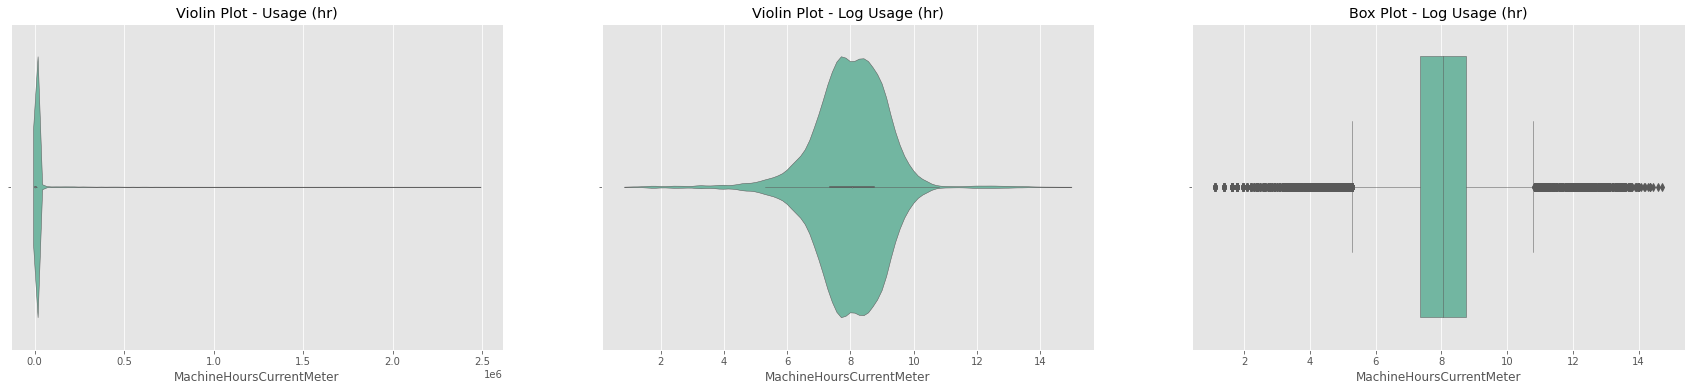

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,6))

axes[0].set_title('Violin Plot - Usage (hr)')
sns.violinplot(x=x, linewidth=.5, ax=axes[0], palette='Set2')

axes[1].set_title('Violin Plot - Log Usage (hr)')
sns.violinplot(x=np.log1p(x), linewidth=.5, ax=axes[1], palette='Set2')

axes[2].set_title('Box Plot - Log Usage (hr)')
sns.boxplot(x=np.log1p(x), linewidth=.5, ax=axes[2], palette='Set2')

In [34]:
find_feature(trn, 'MachineHoursCurrentMeter', threshold=.9)

,importance,rank,norm_cummulative
features,,,
fiProductClassDesc,0.127725,1,0.127725
MachineID,0.124898,2,0.252623
state,0.108771,3,0.361394
YearMade,0.104003,4,0.465396
fiBaseModel,0.092879,5,0.558276
auctioneerID,0.070368,6,0.628644
ModelID,0.058886,7,0.687529
datasource,0.049187,8,0.736716
fiSecondaryDesc,0.045930,9,0.782646


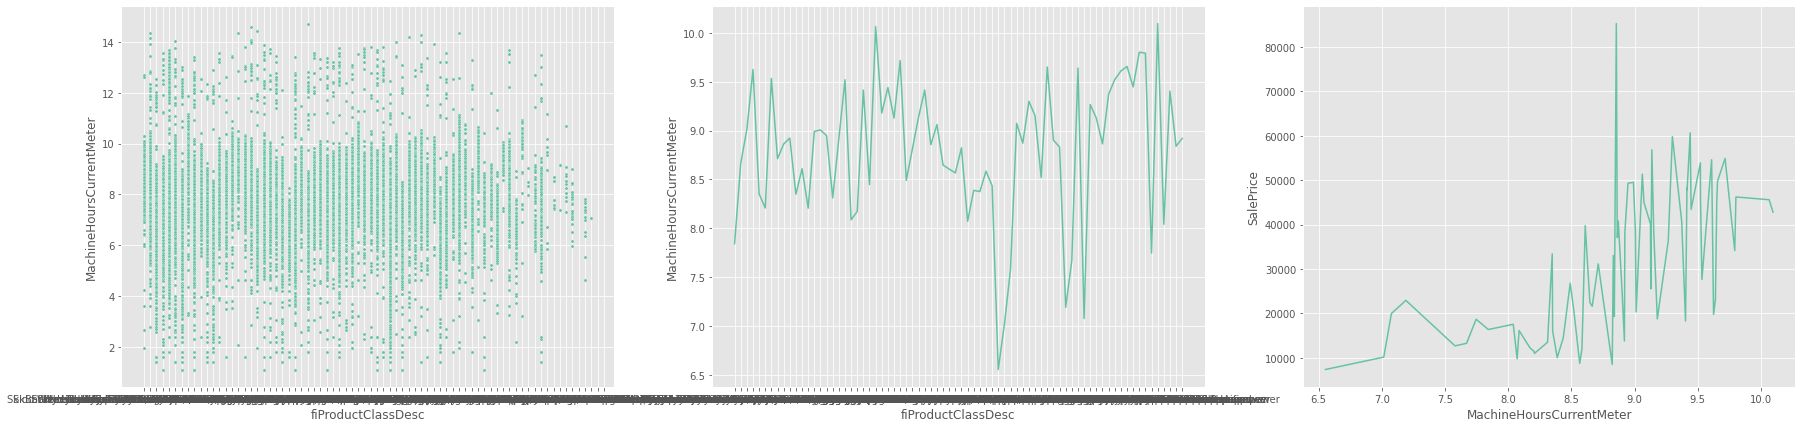

In [35]:
tmp = trn.groupby('fiProductClassDesc').mean()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 7))
sns.scatterplot(x=trn.fiProductClassDesc, y=np.log1p(x), s=10, ax=axes[0])
sns.lineplot(x=tmp.index, y=np.log1p(tmp.MachineHoursCurrentMeter), ax=axes[1])
sns.lineplot(x=np.log1p(tmp.MachineHoursCurrentMeter), y=tmp.SalePrice, ax=axes[2])

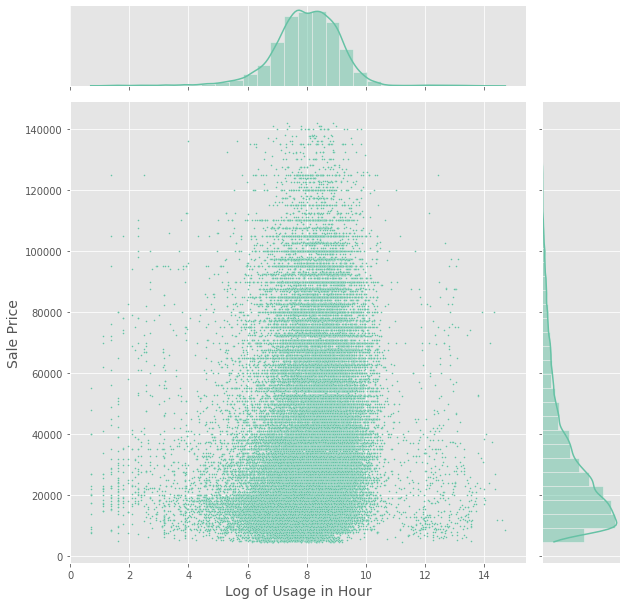

In [36]:
mh = sns.JointGrid(x=np.log(x), y=train.SalePrice, height=8.5, palette='Set2' )
mh.plot_joint(sns.scatterplot, s=3)
mh.plot_marginals(sns.histplot, kde=True, bins=30)
mh.set_axis_labels(xlabel='Log of Usage in Hour', ylabel='Sale Price', fontsize=14)

In [37]:
train.MachineHoursCurrentMeter = np.log1p(train.MachineHoursCurrentMeter)
valid.MachineHoursCurrentMeter = np.log1p(valid.MachineHoursCurrentMeter)

In [38]:
trn.MachineHoursCurrentMeter = np.log1p(trn.MachineHoursCurrentMeter)
val.MachineHoursCurrentMeter = np.log1p(val.MachineHoursCurrentMeter)

In [39]:
def groupby_fill(df, y, by, to_fill=None):
    if to_fill is None:
        groups = df.groupby(by, dropna=False)[y]
        to_fill = groups.mean().to_dict()
    result = df[y].fillna(df[by].map(to_fill))
    if result.isna().sum()!=0:
        return result.fillna(df[y].mean()), to_fill
    else: return result, to_fill

In [40]:
by = 'fiProductClassDesc'

x1t, to_fill = groupby_fill(trn, 'MachineHoursCurrentMeter', by)
x1v, _ = groupby_fill(val, 'MachineHoursCurrentMeter', by, to_fill)

x0t = trn.MachineHoursCurrentMeter.fillna(trn.MachineHoursCurrentMeter.mean())
x0v = val.MachineHoursCurrentMeter.fillna(trn.MachineHoursCurrentMeter.mean())

compare_features([x0t, x0v],[x1t, x1v], (yt, yv))

(365928,) (35197,)
(365928,) (35197,)


[0.7597793939523478, 0.6714703700899116]

In [41]:
train.MachineHoursCurrentMeter.describe()

count    69639.000000
mean         7.989193
std          1.190166
min          1.098612
25%          7.360740
50%          8.051660
75%          8.743292
max         14.725099
Name: MachineHoursCurrentMeter, dtype: float64

In [42]:
train['MachineHoursCurrentMeter_na'] = train.MachineHoursCurrentMeter.isna()
valid['MachineHoursCurrentMeter_na'] = valid.MachineHoursCurrentMeter.isna()

train.MachineHoursCurrentMeter, to_fill = groupby_fill(train, 'MachineHoursCurrentMeter', 'fiProductClassDesc')
valid.MachineHoursCurrentMeter, _ = groupby_fill(valid, 'MachineHoursCurrentMeter', 'fiProductClassDesc', to_fill)

In [43]:
train.MachineHoursCurrentMeter.describe()

count    401125.000000
mean          8.071726
std           0.718003
min           1.098612
25%           7.785721
50%           8.067926
75%           8.543728
max          14.725099
Name: MachineHoursCurrentMeter, dtype: float64

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


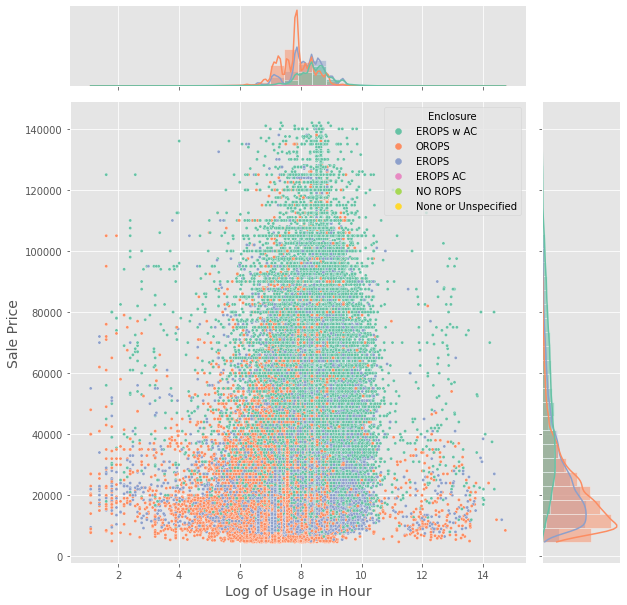

In [44]:
mh = sns.JointGrid(data=train, x='MachineHoursCurrentMeter', y='SalePrice', 
                   height=8.5, hue='Enclosure', palette='Set2' )
mh.plot_joint(sns.scatterplot, s=10)
mh.plot_marginals(sns.histplot, kde=True, bins=30)
mh.set_axis_labels(xlabel='Log of Usage in Hour', ylabel='Sale Price', fontsize=14)

### `MachineID`

In [45]:
x = trn.MachineID.copy()
x.nunique(), x.isna().sum()

(313558, 0)

In [46]:
print(data_dict.loc['MachineID'])
x.value_counts()[:20]

Description      identifier for a particular machine;  machines may have multiple sales
Name: MachineID, dtype: object


1537322    12
496242     12
569515     12
843769     12
1254935    12
1368084    11
1116738    11
1408335    11
837675     11
1489686    11
1314624    11
1361922    10
434372     10
1046204    10
1302516    10
880205     10
1480433    10
285303     10
182370     10
892131     10
Name: MachineID, dtype: int64

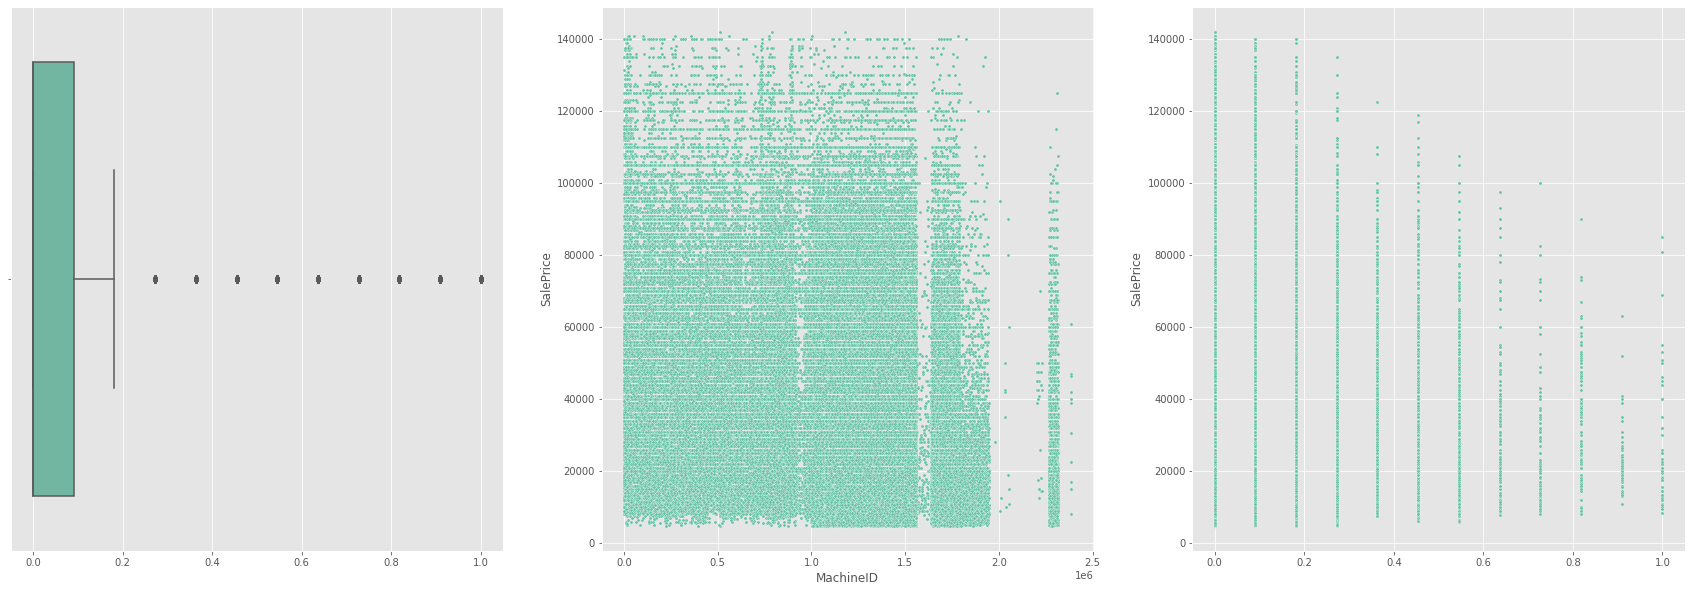

In [47]:
from sklearn.preprocessing import robust_scale, minmax_scale
x0 = minmax_scale(x.map(x.value_counts().to_dict()))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
sns.boxplot(x=x0, ax=axes[0])
sns.scatterplot(x=x, y=trn.SalePrice, s=10, ax=axes[1])
sns.scatterplot(x=x0, y=trn.SalePrice, s=10, ax=axes[2])

In [48]:
x1t = pd.Series(minmax_scale(trn.MachineID.map(trn.MachineID.value_counts().to_dict())))
x1v = pd.Series(minmax_scale(val.MachineID.map(val.MachineID.value_counts().to_dict())))

x0t = trn.MachineID
x0v = val.MachineID

compare_features([x0t, x0v],[x1t, x1v], (yt, yv))

(365928,) (35197,)
(365928,) (35197,)


[0.9403610502518631, 0.7191934008855607]

In [49]:
trn.MachineID = minmax_scale(trn.MachineID.map(trn.MachineID.value_counts().to_dict()))
val.MachineID = minmax_scale(val.MachineID.map(val.MachineID.value_counts().to_dict()))

In [50]:
train.MachineID = minmax_scale(train.MachineID.map(train.MachineID.value_counts(dropna=False)))
valid.MachineID = minmax_scale(valid.MachineID.map(valid.MachineID.value_counts(dropna=False)))

### `ModelID`

We should drop this feature for 3 reasons:
1. It's is the identifier for `fiModelDesc`, which is already excluded.
2. The mean by group of its values does not show any specific trend with `SalePrice`
3. It's highly correlated with `fiBaseModel`, `fiSecondaryDesc`, `fiModelSeries`, `fiModelDescriptor`, which themselves are the disaggregation of `fiModelDesc`.

In [51]:
data_dict.loc['ModelID']

Description      identifier for a unique machine model (i.e. fiModelDesc)
Name: ModelID, dtype: object

In [52]:
find_feature(trn, 'ModelID', threshold=.9)

,importance,rank,norm_cummulative
features,,,
fiBaseModel,0.205288,1,0.205288
fiProductClassDesc,0.203684,2,0.408972
fiSecondaryDesc,0.164415,3,0.573386
fiModelSeries,0.125950,4,0.699337
fiModelDescriptor,0.086439,5,0.785776
YearMade,0.077675,6,0.863451
ProductGroupDesc,0.029517,7,0.892968


In [53]:
x = trn.ModelID.copy()
x.nunique(), x.isna().sum()

(5040, 0)

In [54]:
x.value_counts()

3538     4529
3170     4141
4604     4016
4605     3921
3362     3790
         ... 
3770        1
22211       1
22068       1
24566       1
21724       1
Name: ModelID, Length: 5040, dtype: int64

In [55]:
# calculate variance by ModelID group
# scale down using log1p
# map to the original
x0 = np.log1p(x.map(trn.groupby('ModelID').var().SalePrice.fillna(0)))

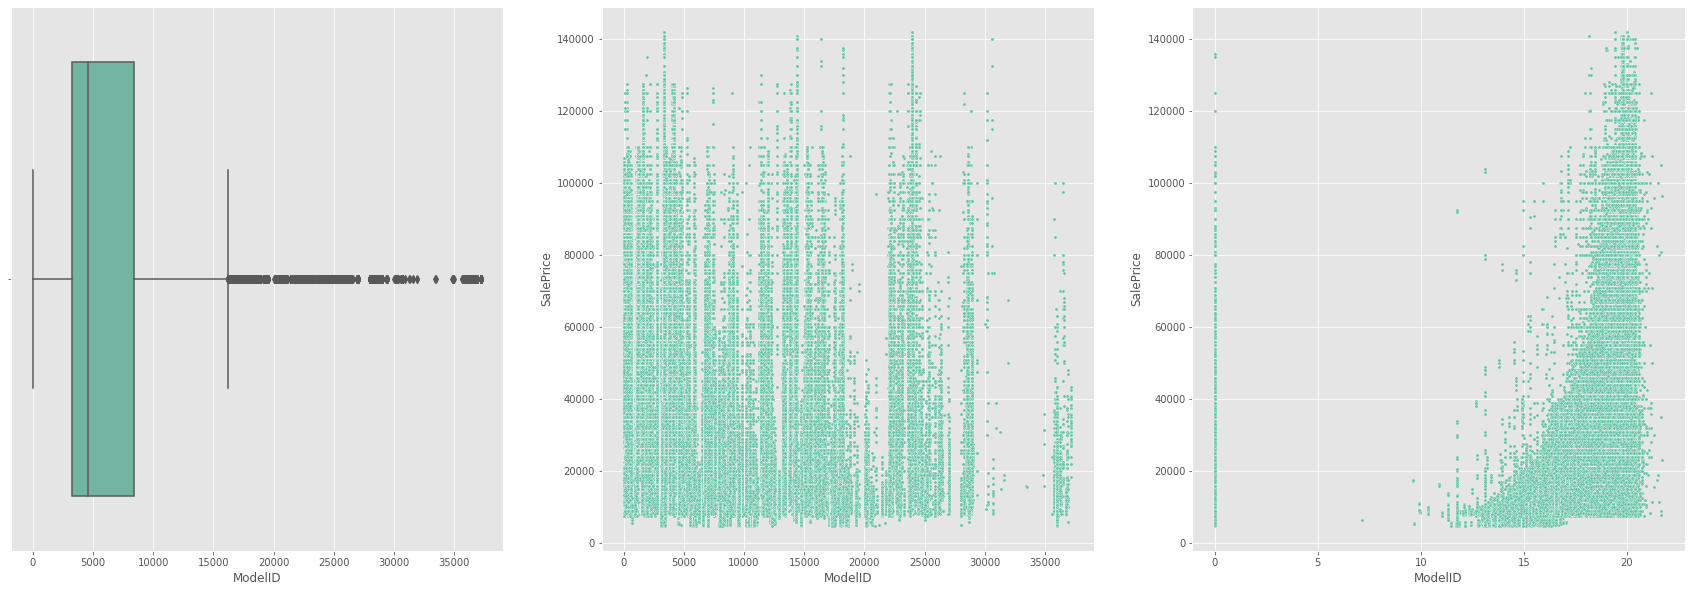

In [56]:
from sklearn.preprocessing import robust_scale, minmax_scale

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
sns.boxplot(x=x, ax=axes[0])
sns.scatterplot(x=x, y=trn.SalePrice, s=10, ax=axes[1])
sns.scatterplot(x=x0, y=trn.SalePrice, s=10, ax=axes[2])


In [57]:
to_fill = trn.groupby('ModelID').var().SalePrice.fillna(0)
x1t = np.log1p(trn.ModelID.map(to_fill)).fillna(0)
x1v = np.log1p(val.ModelID.map(to_fill)).fillna(0)

x0t = trn.ModelID
x0v = val.ModelID

compare_features([x0t, x0v],[x1t, x1v], (yt, yv))

(365928,) (35197,)
(365928,) (35197,)


[0.3146739867343793, 0.3323938068304897]

In [58]:
to_fill = train.groupby('ModelID').var().SalePrice.fillna(0)
train.ModelID = np.log1p(train.ModelID.map(to_fill)).fillna(0)
valid.ModelID = np.log1p(valid.ModelID.map(to_fill)).fillna(0)

In [59]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier().fit(trn.SalePrice.values[:, None], trn.ModelID)

In [60]:
js = JamesSteinEncoder()

# variables with i suffix mean they includes ModelID
# variables with o suffix mean they excludes ModelID
Xi = js.fit_transform(trn.drop(columns=['SalePrice', 'saledate']), trn.SalePrice).dropna(axis=1)
Vi = js.transform(val.drop(columns=['SalePrice', 'saledate']))[Xi.columns]
Xo = js.fit_transform(trn.drop(columns=['SalePrice', 'saledate', 'ModelID']), trn.SalePrice).dropna(axis=1)
Vo = js.transform(val.drop(columns=['SalePrice', 'saledate','ModelID']))[Xo.columns]
Ti = DecisionTreeRegressor().fit(Xi, np.log1p(trn.SalePrice))
To = DecisionTreeRegressor().fit(Xo, np.log1p(trn.SalePrice))

np.sqrt(mean_squared_error(np.log1p(val.SalePrice), Ti.predict(Vi))), \
np.sqrt(mean_squared_error(np.log1p(val.SalePrice), To.predict(Vo)))
# 0.3953527620227076

(0.39732423465935957, 0.405526389525421)

In [61]:
# for df in [train, valid, trn, val]:
#    df.drop(columns=['ModelID'], inplace=True)

## Categorical Variables

### `ProductSize`

In [62]:
y = trn.SalePrice

In [63]:
trn.ProductSize.value_counts()

Medium            56408
Large / Medium    44470
Small             24567
Mini              22564
Large             19740
Compact            5453
Name: ProductSize, dtype: int64

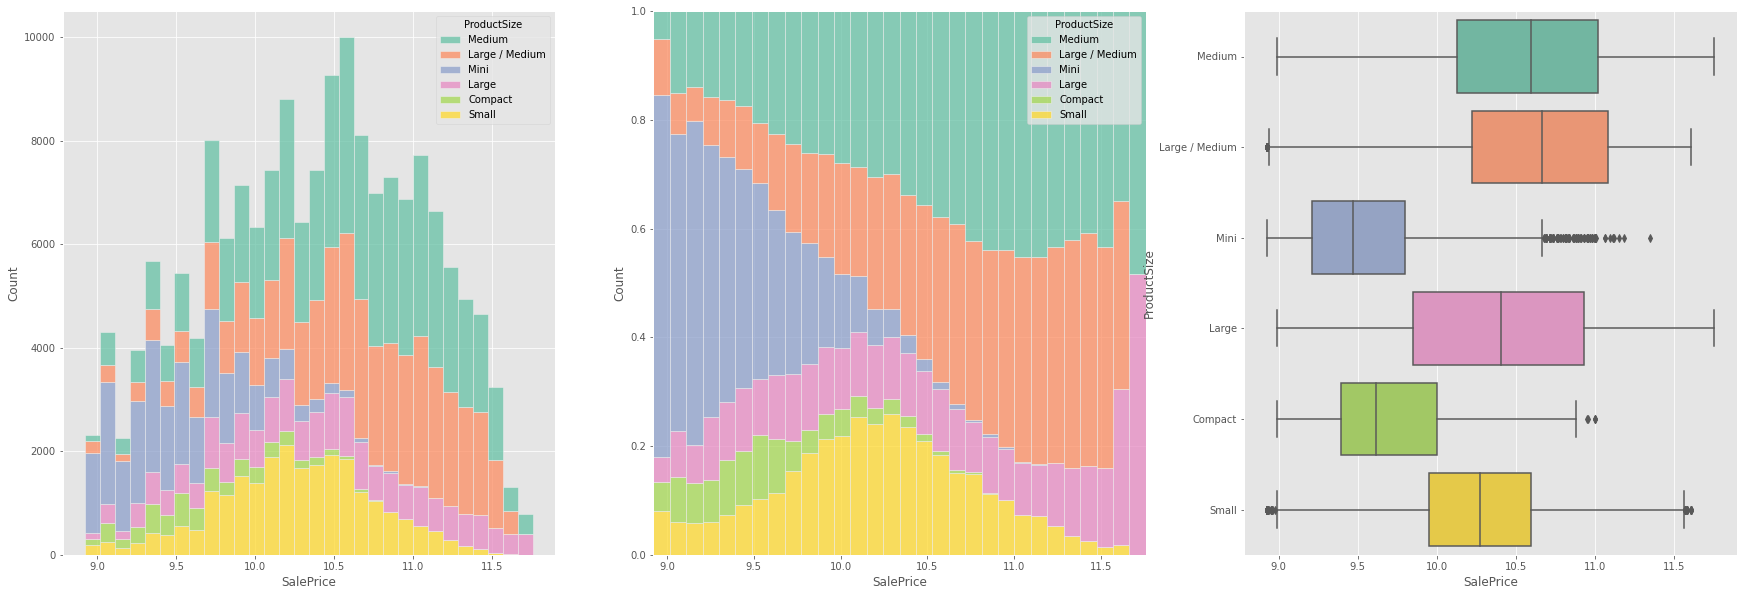

In [64]:
fig, axes = plt.subplots(ncols=3, figsize=(30, 10))
sns.histplot(x=np.log1p(y), bins=30, hue=trn.ProductSize, multiple='stack', ax=axes[0])
sns.histplot(x=np.log1p(y), bins=30, hue=trn.ProductSize, multiple='fill', ax=axes[1])
sns.boxplot(x=np.log1p(y), y=trn.ProductSize, ax=axes[2])

### `Enclosure`

In [65]:
y = trn.SalePrice

In [66]:
trn.Enclosure.value_counts()

OROPS                  160935
EROPS                  130781
EROPS w AC              73881
EROPS AC                   15
NO ROPS                     3
None or Unspecified         2
Name: Enclosure, dtype: int64

In [67]:
to_replace = {
    'EROPS AC': 'EROPS w AC',
    'None or Unspecified': 'NO ROPS'
}

In [68]:
for df in [train, valid, trn, val]:
    df.Enclosure.replace(to_replace, inplace=True)

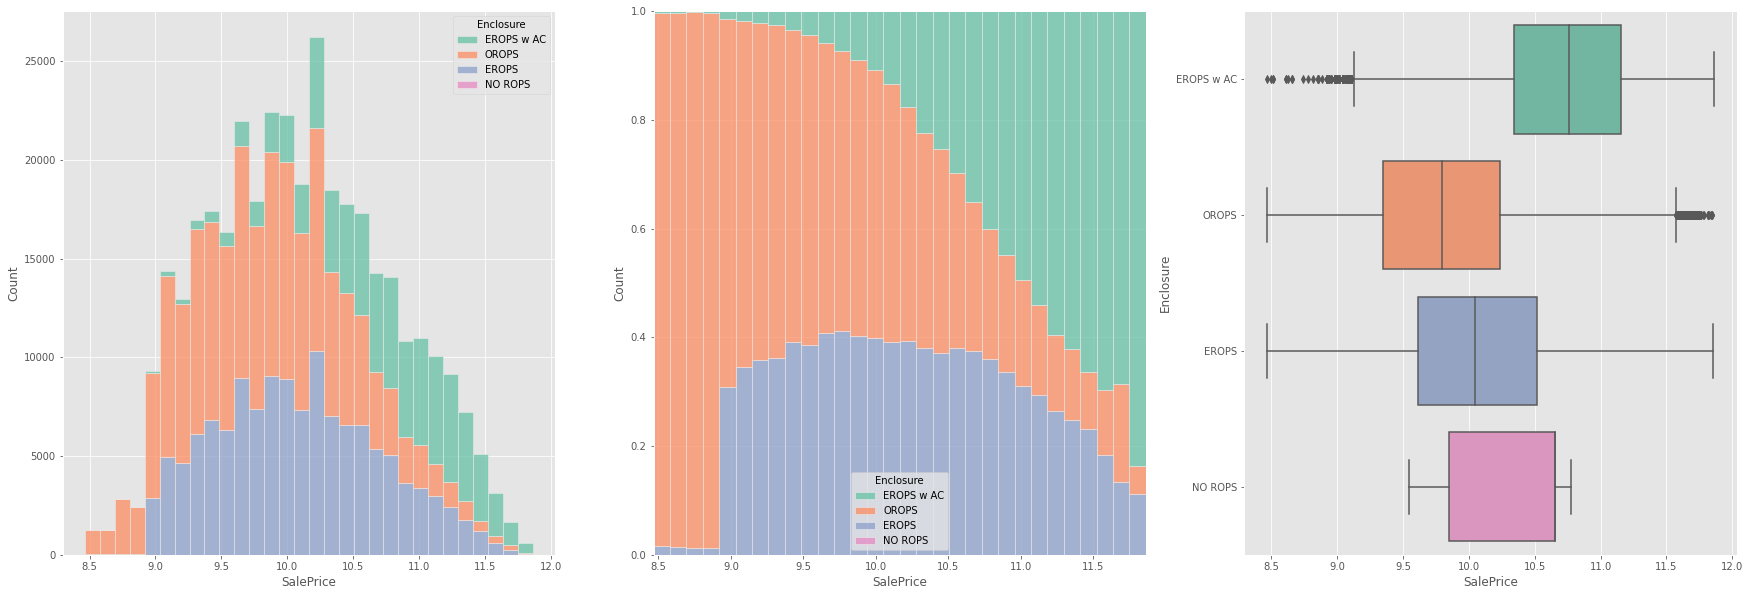

In [69]:
fig, axes = plt.subplots(ncols=3, figsize=(30, 10))
sns.histplot(x=np.log1p(y), bins=30, hue=trn.Enclosure, multiple='stack', ax=axes[0])
sns.histplot(x=np.log1p(y), bins=30, hue=trn.Enclosure, multiple='fill', ax=axes[1])
sns.boxplot(x=np.log1p(y), y=trn.Enclosure, ax=axes[2])

### fiProductClassDesc

In [70]:
trn[['ProductGroupDesc', 'fiProductClassDesc']]

,ProductGroupDesc,fiProductClassDesc
0,Wheel Loader,Wheel Loader - 110.0 to 120.0 Horsepower
1,Wheel Loader,Wheel Loader - 150.0 to 175.0 Horsepower
2,Skid Steer Loaders,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity
4,Skid Steer Loaders,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity
5,Backhoe Loaders,Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth
...,...,...
392262,Wheel Loader,Wheel Loader - 120.0 to 135.0 Horsepower
392263,Wheel Loader,Wheel Loader - 120.0 to 135.0 Horsepower
392265,Track Type Tractors,"Track Type Tractor, Dozer - 160.0 to 190.0 Horsepower"
392266,Wheel Loader,Wheel Loader - 40.0 to 60.0 Horsepower


In [71]:
def disassemble(df):
    tmp = df.fiProductClassDesc.str.split(r'(\d+\.?\d*.+\d+\.?\d*) | (\d+\.?\d*\s?\+\s)', expand=True).iloc[:, 1:]
    tmp = tmp.replace({None:""}).astype(str) 
    measure = tmp.iloc[:, 0:2].sum(axis=1)
    unit = tmp.iloc[:,-1]
    tmp = pd.concat((measure, unit), axis=1)
    tmp.columns = ['Measure', 'Unit']
    result = tmp.pivot(index=None, columns='Unit', values='Measure')
    return result.iloc[:, 1:]

In [72]:
# variables with i suffix mean they includes ModelID
# variables with o suffix mean they excludes ModelID

Xi = pd.concat((trn, disassemble(trn)), axis=1)
Vi = pd.concat((val, disassemble(val)), axis=1)
js = JamesSteinEncoder()
Xi = js.fit_transform(Xi.drop(columns=['SalePrice', 'saledate','fiProductClassDesc']), Xi.SalePrice).dropna(axis=1)
Vi = js.transform(Vi.drop(columns=['SalePrice', 'saledate','fiProductClassDesc']))[Xi.columns]

js = JamesSteinEncoder()
Xo = js.fit_transform(trn.drop(columns=['SalePrice', 'saledate']), trn.SalePrice).dropna(axis=1)
Vo = js.transform(val.drop(columns=['SalePrice', 'saledate']))[Xo.columns]

Ti = DecisionTreeRegressor().fit(Xi, np.log1p(trn.SalePrice))
To = DecisionTreeRegressor().fit(Xo, np.log1p(trn.SalePrice))

np.sqrt(mean_squared_error(np.log1p(val.SalePrice), Ti.predict(Vi))), \
np.sqrt(mean_squared_error(np.log1p(val.SalePrice), To.predict(Vo)))

(0.39509353350486653, 0.39535094354024747)

In [73]:
train = pd.concat((train, disassemble(train)), axis=1)
train.drop(columns='fiProductClassDesc', inplace=True)
valid = pd.concat((valid, disassemble(valid)), axis=1)
valid.drop(columns='fiProductClassDesc', inplace=True)


### `ProductGroupDesc`

In [74]:
trn.ProductGroupDesc.value_counts()

Track Excavators       91745
Track Type Tractors    73952
Backhoe Loaders        72993
Wheel Loader           65035
Skid Steer Loaders     38879
Motor Graders          23324
Name: ProductGroupDesc, dtype: int64

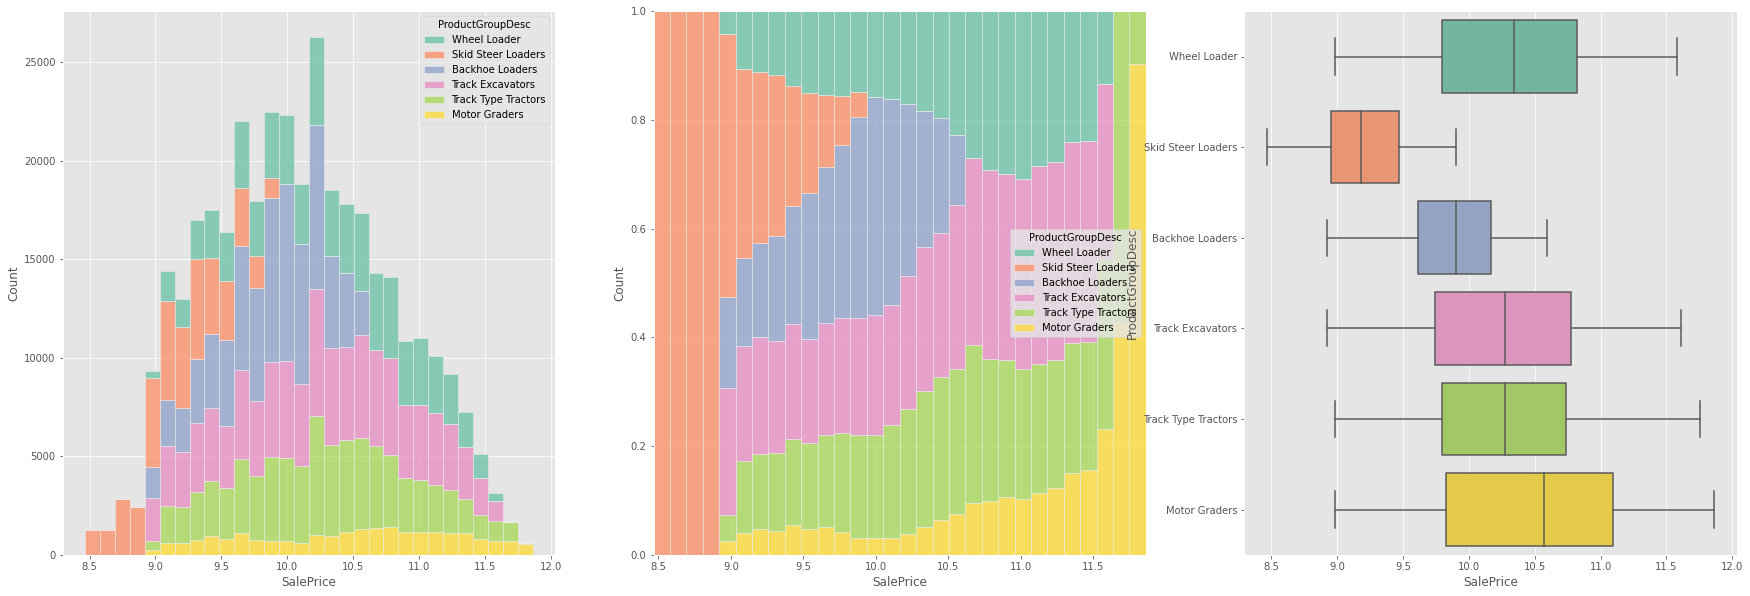

In [75]:
fig, axes = plt.subplots(ncols=3, figsize=(30, 10))
sns.histplot(x=np.log1p(y), bins=30, hue=trn.ProductGroupDesc, multiple='stack', ax=axes[0])
sns.histplot(x=np.log1p(y), bins=30, hue=trn.ProductGroupDesc, multiple='fill', ax=axes[1])
sns.boxplot(x=np.log1p(y), y=trn.ProductGroupDesc, ax=axes[2])

## Datetime Variable

In [78]:
trn.saledate.describe(datetime_is_numeric=True)

count                           365928
mean     2003-12-03 18:47:43.094379520
min                1989-01-17 00:00:00
25%                2000-03-30 00:00:00
50%                2005-05-12 00:00:00
75%                2008-08-27 00:00:00
max                2010-12-30 00:00:00
Name: saledate, dtype: object

In [80]:
valid.saledate.describe(datetime_is_numeric=True)

count                            11573
mean     2012-03-06 02:18:59.134191616
min                2012-01-01 00:00:00
25%                2012-02-13 00:00:00
50%                2012-03-08 00:00:00
75%                2012-03-28 00:00:00
max                2012-04-28 00:00:00
Name: saledate, dtype: object

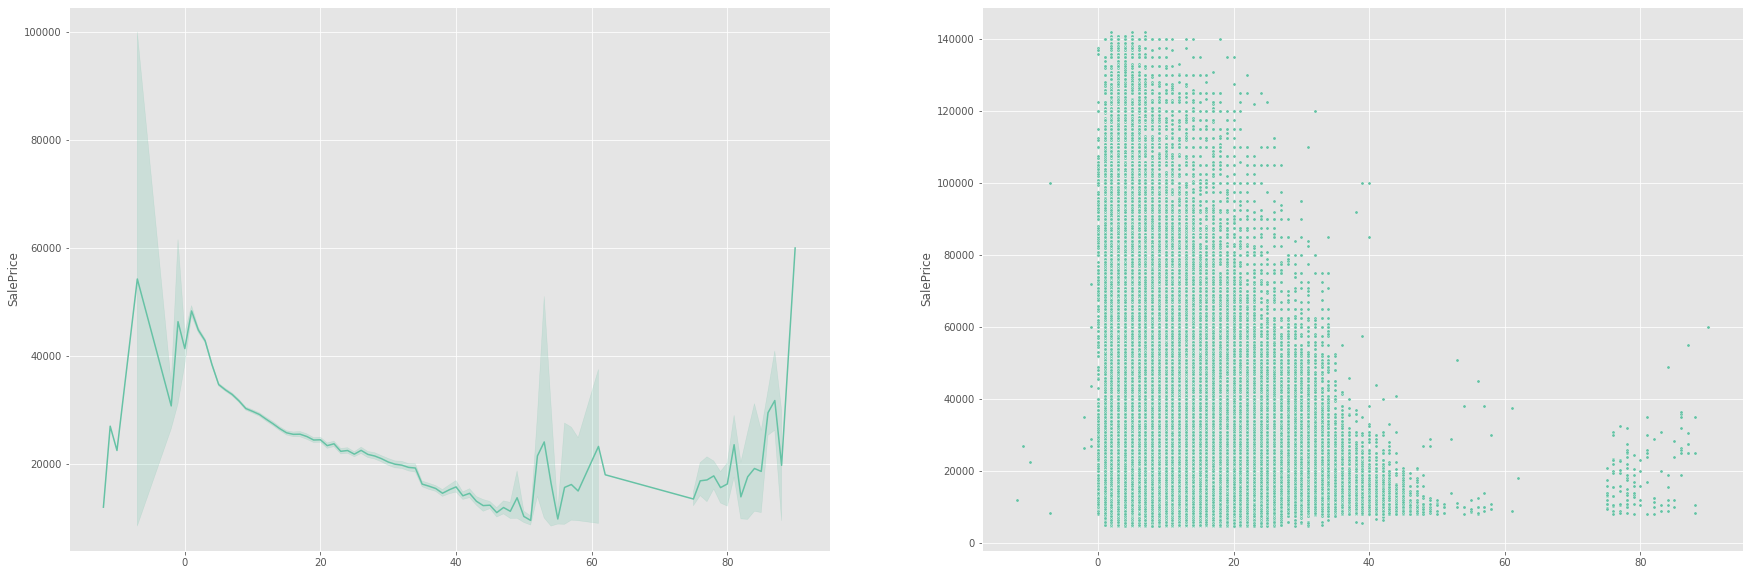

In [110]:
YearSold = trn.saledate.dt.year
# tmp = pd.concat((YearSold, trn.SalePrice), axis=1).groupby('saledate').mean().SalePrice
# tmp = trn.groupby('saledate').mean().SalePrice
fig, axes = plt.subplots(ncols=2, figsize=(30, 10))
tmp = trn.saledate.dt.year - trn.YearMade
sns.lineplot(x=tmp, y=trn.SalePrice, ax=axes[0])
sns.scatterplot(x=tmp, y=trn.SalePrice, s=10, ax=axes[1])



In [113]:
(trn.saledate.dt.year - trn.YearMade).describe()

count    330409.000000
mean         10.108496
std           7.535772
min         -12.000000
25%           5.000000
50%           8.000000
75%          13.000000
max          90.000000
dtype: float64

In [114]:
(valid.saledate.dt.year - valid.YearMade).describe()

count    11573.000000
mean        13.192825
std          8.000778
min         -2.000000
25%          7.000000
50%         11.000000
75%         17.000000
max         59.000000
dtype: float64

In [131]:
x1t = np.abs(trn.saledate.dt.year - trn.YearMade)
x1t = x1t.fillna(x1t.mean())
x1v = np.abs(val.saledate.dt.year - val.YearMade)
x1v = x1v.fillna(x1v.mean())

x0t = trn.saledate.dt.year
x0v = val.saledate.dt.year

compare_features([x0t, x0v],[x1t, x1v], (yt, yv))

(365928,) (35197,)
(365928,) (35197,)


[0.718124390353816, 0.7016358950522725]

In [136]:
train['MadeToSold'] = (train.saledate.dt.year - train.YearMade).abs()
valid['MadeToSold'] = (valid.saledate.dt.year - valid.YearMade).abs()

## Persist Data for Later Use

In [138]:
train.shape, valid.shape

((401125, 56), (11573, 56))

In [139]:
# persist data
train.to_feather(os.path.join(PROJECT_DIR, 'data', 'preproc_train.feather'))
valid.to_feather(os.path.join(PROJECT_DIR, 'data', 'preproc_valid.feather'))

In [ ]:
# persist data
train.to_feather(os.path.join(PROJECT_DIR, 'data', 'raw_train.feather'))
valid.to_feather(os.path.join(PROJECT_DIR, 'data', 'raw_valid.feather'))
data_dict.to_feather(os.path.join(PROJECT_DIR, 'data', 'data_dict.feather'))